In [7]:
import pandas as pd
import numpy as np
from numpy import pi
from scipy import signal
import os
import yaml
import glob

In [8]:
def getBodypartDistance(dataframe, partname1, partname2):
    # retrieves the pixel distance between two bodyparts

    bpt1 = dataframe.xs(partname1, level='bodyparts', axis=1).to_numpy()
    bpt2 = dataframe.xs(partname2, level='bodyparts', axis=1).to_numpy()

    bptDistance = np.sqrt(np.sum(np.square(bpt1[:, [0, 1]] - bpt2[:, [0, 1]]), axis=1))
    return bptDistance


def getAnimalCentroid(dataframe):
    scorer = dataframe.columns.get_level_values(0).unique()[0]
    bptNames = dataframe.columns.get_level_values(1).unique()
    aniXpos, aniYpos = np.zeros((nFrames, len(bptNames[0:8]))), np.zeros((nFrames, len(bptNames[0:8])))

    for i, nm in enumerate(bptNames[0:8]):
        aniXpos[:, i] = dataframe[scorer][nm]['x']
        aniYpos[:, i] = dataframe[scorer][nm]['y']

    xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
    centroid = np.column_stack((xCenter, yCenter))

    return centroid


def getBodypartAngle(dataframe, partName1, partName2):
    # retrieves the angle between two bodyparts

    bpt1 = dataframe.xs(partName1, level='bodyparts', axis=1).to_numpy()
    bpt2 = dataframe.xs(partName2, level='bodyparts', axis=1).to_numpy()

    angle = np.arctan2(bpt2[:, 1] - bpt1[:, 1], bpt2[:, 0] - bpt1[:, 0])
    return angle


def circularDistance(ang1, ang2):
    # efficiently computes the circular distance between two angles

    circdist = np.angle(np.exp(1j * ang1) / np.exp(1j * ang2))

    return circdist


def wrapTo2pi(ang):
    # wraps a set of values to fit between zero and 2Pi

    positiveValues = (ang > 0)
    wrappedAng = ang % (2 * pi)
    wrappedAng[ang == 0 & positiveValues] = 2 * pi

    return wrappedAng


def getRelativeOrientations(ani1, ani2):

    normPos = ani2[['XCenter', 'YCenter']] - ani1[['XCenter', 'YCenter']]
    absoluteAngle = np.arctan2(normPos['YCenter'], normPos['XCenter'])
    fA = circularDistance(absoluteAngle, ani2['heading'])
    aBetween = circularDistance(ani1['heading'],ani2['heading'])

    return fA, aBetween


def removeJumps(dataframe, maxJumpLength):
    # removes large jumps in the x/y position of bodyparts, usually resulting from swaps between animals

    # get all column names
    scorer = dataframe.columns.get_level_values(0)[0]
    bps = list(dataframe.columns.levels[1])
    params = list(dataframe.columns.levels[2])
    dataframeMod = dataframe.copy()

    for i, partName in enumerate(bps):

        xDiff = pd.Series(np.diff(dataframe[scorer][partName]['x']))
        yDiff = pd.Series(np.diff(dataframe[scorer][partName]['y']))

        xJumpsPositive = signal.find_peaks(xDiff.interpolate(), threshold=200)
        xJumpsNegative = signal.find_peaks(xDiff.interpolate() * -1, threshold=200)
        yJumpsPositive = signal.find_peaks(yDiff.interpolate(), threshold=200)
        yJumpsNegative = signal.find_peaks(yDiff.interpolate() * -1, threshold=200)

        toKill = np.zeros((len(yDiff),), dtype=bool)

        for j in range(len(xJumpsPositive[0])):
            if np.any((xJumpsNegative[0] > xJumpsPositive[0][j]) & (
                    xJumpsNegative[0] < xJumpsPositive[0][j] + maxJumpLength)):
                endIdx = np.where((xJumpsNegative[0] > xJumpsPositive[0][j]) & (
                        xJumpsNegative[0] < xJumpsPositive[0][j] + maxJumpLength))
                toKill[xJumpsPositive[0][j]:xJumpsNegative[0][endIdx[0][0]]] = True
            else:
                toKill[xJumpsPositive[0][j]] = True

        for j in range(len(xJumpsNegative[0])):

            if np.any((xJumpsPositive[0] > xJumpsNegative[0][j]) & (
                    xJumpsPositive[0] < xJumpsNegative[0][j] + maxJumpLength)):
                endIdx = np.where((xJumpsPositive[0] > xJumpsNegative[0][j]) & (
                        xJumpsPositive[0] < xJumpsNegative[0][j] + maxJumpLength))
                toKill[xJumpsNegative[0][j]:xJumpsPositive[0][endIdx[0][0]]] = True
            else:
                toKill[xJumpsNegative[0][j]] = True

        for j in range(len(yJumpsPositive[0])):
            if np.any((yJumpsNegative[0] > yJumpsPositive[0][j]) & (
                    yJumpsNegative[0] < yJumpsPositive[0][j] + maxJumpLength)):
                endIdx = np.where((yJumpsNegative[0] > yJumpsPositive[0][j]) & (
                        yJumpsNegative[0] < yJumpsPositive[0][j] + maxJumpLength))
                toKill[yJumpsPositive[0][j]:yJumpsNegative[0][endIdx[0][0]]] = True
            else:
                toKill[yJumpsPositive[0][j]] = True

        for j in range(len(yJumpsNegative[0])):
            if np.any((yJumpsPositive[0] > yJumpsNegative[0][j]) & (
                    yJumpsPositive[0] < yJumpsNegative[0][j] + maxJumpLength)):
                endIdx = np.where((yJumpsPositive[0] > yJumpsNegative[0][j]) & (
                        yJumpsPositive[0] < yJumpsNegative[0][j] + maxJumpLength))
                toKill[yJumpsNegative[0][j]:yJumpsPositive[0][endIdx[0][0]]] = True
            else:
                toKill[yJumpsNegative[0][j]] = True

        toKill = np.insert(toKill, 1, False)

        dataframeMod.loc[toKill, (scorer, partName, params)] = np.nan

    return dataframeMod


def butterLowpassFilter(data, cutoff, fs, order):
    # implements a butterworth lowpass filter to a signal (data) sampled at fs, with a set cutoff.

    nyq = fs / 2
    adjustedCutoff = cutoff / nyq
    b, a = signal.butter(order, adjustedCutoff, btype='low', analog=False)
    filteredSignal = signal.filtfilt(b, a, data)

    return filteredSignal


def getContinousNumbers(nums):
    # returns a list of continous numbers found in an array

    nums = sorted(set(nums))
    gaps = [[s, e] for s, e in zip(nums, nums[1:]) if s + 1 < e]
    edges = iter(nums[:1] + sum(gaps, []) + nums[-1:])
    return list(zip(edges, edges))

In [9]:
#rootdir = '/mnt/minerva/courtship-free-behavior/maDLCv2' #maDLCv2'
rootdir = '/Volumes/Julie/courtship-free-behavior/maDLCv2' #maDLCv2'
projectname = 'MMFv2'
experiment = 'MF-20mm-cantons-RL'
projectdir = os.path.join(rootdir, projectname) 
# load config file
cfg_fpath = os.path.join(projectdir, 'config.yaml')
with open(cfg_fpath, "r") as f:
    cfg = yaml.load(f, Loader=yaml.SafeLoader)
# get list of tracked files
srcdir = os.path.join(projectdir, experiment)
suffix = 'el_IDcorrected'
tracked_files = glob.glob(os.path.join(srcdir, '*', '*_{}.h5'.format(suffix)))
print(len(tracked_files))
# Figure dir
figdir = os.path.join(rootdir, 'figures')
figid = srcdir
print(figid)
if not os.path.exists(figdir):
    os.makedirs(figdir)

13
/Volumes/Julie/courtship-free-behavior/maDLCv2/MMFv2/MF-20mm-cantons-RL


In [10]:
filename = tracked_files[0]
print(filename)

/Volumes/Julie/courtship-free-behavior/maDLCv2/MMFv2/MF-20mm-cantons-RL/MF_030122_3/030122_Canton-S_age5_m_sh_f_gh_3DLC_dlcrnetms5_MMFv2Sep27shuffle1_200000_el_IDcorrected.h5


In [12]:

tracks = pd.read_hdf(filename) #os.path.join(pathname, filename))
scorer = tracks.columns.get_level_values(0)[0]
sampleRate = 60  # Hz
maxJump = 6
tstamp = np.linspace(0, len(tracks) * 1 / sampleRate, len(tracks))
nFrames = len(tracks)

maleName = 'ind1' # double check in the plots for abdomen lengths
femaleName = 'ind2'

femalePositions = tracks.xs(femaleName, level='individuals', axis=1)
female_abdomenlength = getBodypartDistance(femalePositions, 'abdomenTop', 'genitalia')
malePositions = tracks.xs(maleName, level='individuals', axis=1)
male_abdomenlength = getBodypartDistance(malePositions, 'abdomenTop', 'genitalia')

In [39]:
import seaborn as sns
import pylab as pl
import cv2

<AxesSubplot:ylabel='Count'>

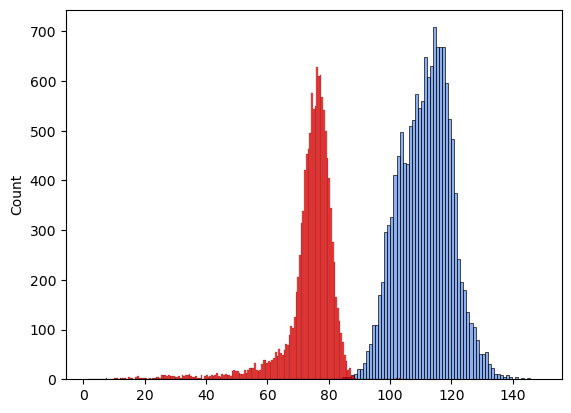

In [19]:
fig, ax = pl.subplots()
sns.histplot(x=female_abdomenlength, color='cornflowerblue', ax=ax)
sns.histplot(x=male_abdomenlength, color='r', ax=ax)

In [20]:
if np.nanmean(female_abdomenlength) < np.nanmean(male_abdomenlength):
    maleName = 'ind2'
    femaleName = 'ind1'

# get female positions
femalePositions = tracks.xs(femaleName, level='individuals', axis=1)
femalePositions = removeJumps(femalePositions, maxJump)
femaleCenter = getAnimalCentroid(femalePositions)

# get male positions
malePositions = tracks.xs(maleName, level='individuals', axis=1)
malePositions = removeJumps(malePositions, maxJump)
maleCenter = getAnimalCentroid(malePositions)

# detect copulation: cut dataframes
copFrame = len(tracks)

/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_7323/670545952.py:20: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)
/var/folders/6z/bhycp6jj4pxg1qt6h_j36h880000gn/T/ipykernel_7323/670545952.py:20: RuntimeWarning: Mean of empty slice
  xCenter, yCenter = np.nanmean(aniXpos, axis=1), np.nanmean(aniYpos, axis=1)


In [21]:
copFrame

15118

In [22]:

# get some more female parameters
femaleParams = pd.DataFrame(getBodypartAngle(femalePositions, 'abdomenTop', 'thoraxCenter'),
                            columns=['heading'])
femaleParams['XCenter'], femaleParams['YCenter'] = femaleCenter[:copFrame, 0], femaleCenter[:copFrame, 1]
femaleParams['linSpeed'] = np.concatenate(
    (np.zeros(1), np.sqrt(np.sum(np.square(np.diff(femaleCenter[:copFrame, ], axis=0)), axis=1))))
leftW = getBodypartAngle(femalePositions, 'thoraxCenter', 'wingLeft')
rightW = getBodypartAngle(femalePositions, 'thoraxCenter', 'wingRight')
femaleParams['leftWingAngle'] = wrapTo2pi(circularDistance(femaleParams['heading'].interpolate(), leftW)) - np.pi
femaleParams['rightWingAngle'] = wrapTo2pi(circularDistance(femaleParams['heading'].interpolate(), rightW)) - np.pi
femaleParams['interWingDistance'] = getBodypartDistance(femalePositions, 'wingRight', 'wingLeft')
femaleParams['abdomenLength'] = getBodypartDistance(femalePositions, 'abdomenTop', 'genitalia')
femaleParams['abdomenWidth'] = getBodypartDistance(femalePositions, 'abdomenLeft', 'abdomenRight')
femaleParams['abdomentipdirection'] = getBodypartAngle(femalePositions, 'genitalia', 'abdomenTop')
femaleParams['abdomentipOffset'] = circularDistance(femaleParams['abdomentipdirection'],femaleParams['heading'])
abdomen_lower_width = getBodypartDistance(femalePositions, 'abdomenLowerLeft', 'abdomenLowerRight')
femaleParams['abdomenLowerwidth'] = abdomen_lower_width
femaleParams['abdomenWidthRatio'] = abdomen_lower_width / femaleParams['abdomenWidth']
femaleParams['abdomentipdirection'] = getBodypartAngle(femalePositions, 'genitalia', 'abdomenTop')
femaleParams['abdomentipOffset'] = circularDistance(femaleParams['abdomentipdirection'],femaleParams['heading'])
ableft = getBodypartAngle(femalePositions, 'genitalia','abdomenLowerLeft')
abright = getBodypartAngle(femalePositions, 'genitalia','abdomenLowerRight')
abmidline = getBodypartAngle(femalePositions, 'genitalia', 'abdomenCenter')
abtip_angle = wrapTo2pi(circularDistance(abright,ableft))
femaleParams['abdomen_tip_angle'] = abtip_angle
abtip_left = wrapTo2pi(circularDistance(abmidline,ableft))
abtip_right = wrapTo2pi(circularDistance(abright,abmidline))
abtip_offset = abs(abtip_left - abtip_right)
femaleParams['abdomentipOffset_m2'] = abtip_offset


In [ ]:
# Female leg
midleg_left_1 = getBodypartAngle(femalePositions, 'midlegLeftJoint1', 'thoraxCenter')
midleg_right_1 = getBodypartAngle(femalePositions, 'midlegRightJoint1', 'thoraxCenter')
midleg_left_2 = getBodypartAngle(femalePositions, 'midlegLeftJoint1', 'midlegLeftJoint2')
midleg_right_2 = getBodypartAngle(femalePositions, 'midlegRightJoint1', 'midlegRightJoint2')

midleg_left_Joint1_Ang = wrapTo2pi(circularDistance(midleg_left_1,midleg_left_2))
midleg_right_Joint1_Ang = wrapTo2pi(circularDistance(midleg_right_1,midleg_right_2))
femaleParams['midleg_left_Joint1_Ang'] = midleg_left_Joint1_Ang
femaleParams['midleg_right_Joint1_Ang'] = midleg_right_Joint1_Ang

midleg_left_2p = getBodypartAngle(femalePositions, 'midlegLeftJoint2', 'midlegLeftJoint1')
midleg_right_2p = getBodypartAngle(femalePositions, 'midlegRightJoint2', 'midlegRightJoint1')
midleg_left_3 = getBodypartAngle(femalePositions, 'midlegLeftJoint2', 'midlegLeft')
midleg_right_3 = getBodypartAngle(femalePositions, 'midlegRightJoint2', 'midlegRight')

midleg_left_Joint2_Ang = wrapTo2pi(circularDistance(midleg_left_2p,midleg_left_3))
midleg_right_Joint2_Ang = wrapTo2pi(circularDistance(midleg_right_2p,midleg_right_3))
femaleParams['midleg_left_Joint2_Ang'] = midleg_left_Joint2_Ang
femaleParams['midleg_right_Joint2_Ang'] = midleg_right_Joint2_Ang

hindleg_left_1 = getBodypartAngle(femalePositions, 'hindlegLeftJoint1', 'thoraxCenter')
hindleg_right_1 = getBodypartAngle(femalePositions, 'hindlegRightJoint1', 'thoraxCenter')
hindleg_left_2 = getBodypartAngle(femalePositions, 'hindlegLeftJoint1', 'hindlegLeftJoint2')
hindleg_right_2 = getBodypartAngle(femalePositions, 'hindlegRightJoint1', 'hindlegRightJoint2')

hindleg_left_Joint1_Ang = wrapTo2pi(circularDistance(hindleg_left_1,hindleg_left_2))
hindleg_right_Joint1_Ang = wrapTo2pi(circularDistance(hindleg_right_1,hindleg_right_2))
femaleParams['hindleg_left_Joint1_Ang'] = hindleg_left_Joint1_Ang
femaleParams['hindleg_right_Joint1_Ang'] = hindleg_right_Joint1_Ang

hindleg_left_2p = getBodypartAngle(femalePositions, 'hindlegLeftJoint2', 'hindlegLeftJoint1')
hindleg_right_2p = getBodypartAngle(femalePositions, 'hindlegRightJoint2', 'hindlegRightJoint1')
hindleg_left_3 = getBodypartAngle(femalePositions, 'hindlegLeftJoint2', 'hindlegLeft')
hindleg_right_3 = getBodypartAngle(femalePositions, 'hindlegRightJoint2', 'hindlegRight')

hindleg_left_Joint2_Ang = wrapTo2pi(circularDistance(hindleg_left_2p,hindleg_left_3))
hindleg_right_Joint2_Ang = wrapTo2pi(circularDistance(hindleg_right_2p,hindleg_right_3))
femaleParams['hindleg_left_Joint2_Ang'] = hindleg_left_Joint2_Ang
femaleParams['hindleg_right_Joint2_Ang'] = hindleg_right_Joint2_Ang

In [23]:
# get some more male parameters
maleParams = pd.DataFrame(getBodypartAngle(malePositions, 'abdomenTop', 'thoraxCenter'),
                          columns=['heading'])
maleParams['XCenter'], maleParams['YCenter'] = maleCenter[:copFrame, 0], maleCenter[:copFrame, 1]
maleParams['linSpeed'] = np.concatenate(
    (np.zeros(1), np.sqrt(np.sum(np.square(np.diff(maleCenter[:copFrame, ], axis=0)), axis=1))))
leftW = getBodypartAngle(malePositions, 'thoraxCenter', 'wingLeft')
rightW = getBodypartAngle(malePositions, 'thoraxCenter', 'wingRight')
maleParams['leftWingAngle'] = wrapTo2pi(circularDistance(maleParams['heading'].interpolate(), leftW)) - np.pi
maleParams['rightWingAngle'] = wrapTo2pi(circularDistance(maleParams['heading'].interpolate(), rightW)) - np.pi
maleParams['interWingDistance'] = getBodypartDistance(malePositions, 'wingRight', 'wingLeft')

maleParams['abdomenLength'] = getBodypartDistance(malePositions, 'abdomenTop', 'genitalia')
maleParams['abdomenWidth'] = getBodypartDistance(malePositions, 'abdomenLeft', 'abdomenRight')
maleParams['abdomentipdirection'] = getBodypartAngle(malePositions, 'genitalia', 'abdomenTop')
maleParams['abdomentipOffset'] = circularDistance(maleParams['abdomentipdirection'],maleParams['heading'])
abdomen_lower_width = getBodypartDistance(malePositions, 'abdomenLowerLeft', 'abdomenLowerRight')
maleParams['abdomenLowerwidth'] = abdomen_lower_width
maleParams['abdomenWidthRatio'] = abdomen_lower_width / maleParams['abdomenWidth']
maleParams['abdomentipdirection'] = getBodypartAngle(malePositions, 'genitalia', 'abdomenTop')
maleParams['abdomentipOffset'] = circularDistance(maleParams['abdomentipdirection'],maleParams['heading'])
ableft = getBodypartAngle(malePositions, 'genitalia','abdomenLowerLeft')
abright = getBodypartAngle(malePositions, 'genitalia','abdomenLowerRight')
abmidline = getBodypartAngle(malePositions, 'genitalia', 'abdomenCenter')
abtip_angle = wrapTo2pi(circularDistance(abright,ableft))
maleParams['abdomen_tip_angle'] = abtip_angle
abtip_left = wrapTo2pi(circularDistance(abmidline,ableft))
abtip_right = wrapTo2pi(circularDistance(abright,abmidline))
abtip_offset = abs(abtip_left - abtip_right)
maleParams['abdomentipOffset_m2'] = abtip_offset


In [24]:
# get inter-fly distance based on centroid
IFD = np.sqrt(np.sum(np.square(maleCenter - femaleCenter),axis=1))
femaleParams['dist2Other'] = IFD[:copFrame]
femaleParams['facingAngle'], femaleParams['angBetween'] = getRelativeOrientations(femaleParams, maleParams)

maleParams['dist2Other'] = IFD[:copFrame]
maleParams['facingAngle'], maleParams['angBetween'] = getRelativeOrientations(maleParams, femaleParams)

            #write files

In [26]:
maleParams['leftWingAngle'].min(), maleParams['leftWingAngle'].max() 

(-3.0989789535596386, 2.966813753523253)

In [29]:
maleParams.shape, femaleParams.shape

((15118, 18), (15118, 18))

In [35]:
maleParams['animal_index'] = maleName
maleParams['sex'] = 'male'
femaleParams['animal_index'] = femaleName
femaleParams['sex'] = 'female'

In [36]:
df0 = pd.concat([femaleParams, maleParams], axis=0)
df0.shape

(30236, 20)

# Get video frames to validate

In [64]:
import dlc as dlc
import matplotlib as mpl
import plotting as putil

In [65]:
plot_style='dark'
putil.set_sns_style(style=plot_style)
bg_color='w' if plot_style=='dark' else 'k'

In [66]:
#meta_fpath = '/Users/julianarhee/DeepLabCut/bandensis-dyad-jyr-2022-07-22/videos/NINJAV_S001_S001_T034_008_cDLC_dlcrnetms5_bandensis-dyadJul22shuffle1_50000_meta.pickle'
model_prefix = 'DLC_dlcrnetms5_'
# scorer = df0.columns[0]
fbase = filename.split(model_prefix)[0]
movie_fmt = 'avi'
video_fpath = '{}.{}'.format(fbase, movie_fmt) #esults_fpath.replace('%s_el.h5' % scorer, '.mp4')
assert os.path.exists(video_fpath), "Could not find corresponding video: {}".format(video_fpath)
cap = cv2.VideoCapture(video_fpath)
# N frames should equal size of DCL df
n_frames = cap.get(cv2.CAP_PROP_FRAME_COUNT)

In [72]:
# create a skeleton connector for abdomen only
abdomen_pts = ['abdomenTop', 'abdomenLeft', 'abdomenLowerLeft', 'genitalia', 'abdomenLowerRight', 'abdomenRight']
abdomen_pts_tmp = abdomen_pts.copy()
abdomen_pts_tmp.append(abdomen_pts[0])
abdomen2connect = [[v, abdomen_pts_tmp[i+1]] for i, v in enumerate(abdomen_pts_tmp[0:-1])]
# get indices
bodyparts2connect = cfg["skeleton"]
inds_og  = dlc.get_segment_indices(bodyparts2connect, all_bpts) # bp indices from config file
n_bodyparts = len(np.unique(tracks.columns.get_level_values("bodyparts")[::3]))
all_bpts = tracks.columns.get_level_values("bodyparts")[::3][0:n_bodyparts]
inds_abdomen = dlc.get_segment_indices(abdomen2connect, all_bpts)

In [73]:
animal_colors={'ind1': 'm', 'ind2': 'c'}
pcutoff=0.01
alphavalue=1
skeleton_color=bg_color
bg_color

'w'

M: L -46.98, R 8.27
F: L -0.36, R 6.36


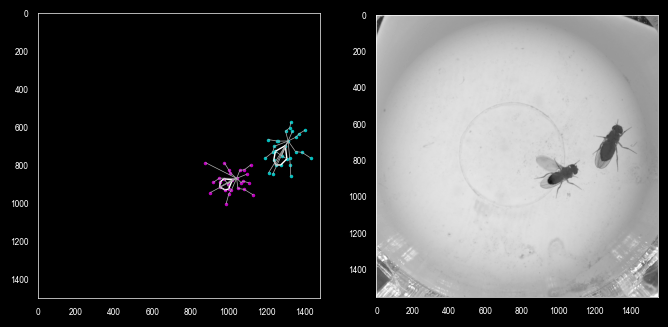

In [113]:
skeleton_color0 = [0.7]*3
markersize=3
skeleton_lw=0.5
lw=1

inds = inds_abdomen.copy()
fig, axn = pl.subplots(1, 2, figsize=(8,4))

bodyparts2plot = set(tracks.columns.get_level_values("bodyparts"))
individuals = set(tracks.columns.get_level_values("individuals"))

ax=axn[0]
ix=33

anglesM = df0[df0['sex']=='male'].loc[ix][['leftWingAngle', 'rightWingAngle']].values
anglesF = df0[df0['sex']=='female'].loc[ix][['leftWingAngle', 'rightWingAngle']].values
print("M: L {:.2f}, R {:.2f}".format(np.rad2deg(anglesM[0]), np.rad2deg(anglesM[1])))
print("F: L {:.2f}, R {:.2f}".format(np.rad2deg(anglesF[0]), np.rad2deg(anglesF[1])))

for ind2plot in individuals:
    curr_col = animal_colors[ind2plot]
    df = tracks.loc(axis=1)[:, ind2plot]
    for bpindex, bp in enumerate(bodyparts2plot):
        prob = df.xs(
            (bp, "likelihood"), level=(-2, -1), axis=1
        ).values.squeeze()
        mask = prob < pcutoff
        temp_x = np.ma.array(
            df.xs((bp, "x"), level=(-2, -1), axis=1).values.squeeze(),
            mask=mask,
        )
        temp_y = np.ma.array(
            df.xs((bp, "y"), level=(-2, -1), axis=1).values.squeeze(),
            mask=mask,
        )
        ax.plot(temp_x[ix], temp_y[ix], ".", color=curr_col, alpha=alphavalue, markersize=markersize)

    nx = int(np.nanmax(df.xs("x", axis=1, level="coords")))
    ny = int(np.nanmax(df.xs("y", axis=1, level="coords")))

    n_frames = df.shape[0]
    xyp = df.values.reshape((n_frames, -1, 3))
    coords = xyp[ix, :, :2]
    coords[xyp[ix, :, 2] < pcutoff] = np.nan
    segs = coords[tuple(zip(*tuple(inds))), :].swapaxes(0, 1) if inds else []
    coll = mpl.collections.LineCollection(segs, colors=skeleton_color, alpha=alphavalue, lw=lw)
    # plot
    ax.add_collection(coll)
    
    segs0 = coords[tuple(zip(*tuple(inds_og))), :].swapaxes(0, 1) if inds_og else []
    col0 = mpl.collections.LineCollection(segs0, colors=skeleton_color0, alpha=alphavalue, lw=skeleton_lw)
    ax.add_collection(col0)
    # axes
    ax.set_xlim(0, nx)
    ax.set_ylim(0, ny)
    ax.set_aspect(1)
    ax.invert_yaxis()

ax=axn[1]
cap.set(1, ix)
ret, im = cap.read()
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) #COLOR_BGR2RGB)
ax.imshow(im, cmap='gray')

In [109]:
wing_open_angle = np.deg2rad(45)
wing_closed_angle = np.deg2rad(10)

leftwing_ext = df0[(df0['sex']=='male') 
                    & (df0['leftWingAngle'].abs()>=wing_open_angle) 
                    & (df0['rightWingAngle'].abs()<wing_closed_angle)]
rightwing_ext = df0[(df0['sex']=='male') 
                    & (df0['leftWingAngle'].abs()<wing_closed_angle) 
                    & (df0['rightWingAngle'].abs()>=wing_open_angle)]

In [111]:
leftwing_ext

,heading,XCenter,YCenter,linSpeed,leftWingAngle,rightWingAngle,interWingDistance,abdomenLength,abdomenWidth,abdomentipdirection,abdomentipOffset,abdomenLowerwidth,abdomenWidthRatio,abdomen_tip_angle,abdomentipOffset_m2,dist2Other,facingAngle,angBetween,animal_index,sex
33,-0.351073,996.424875,873.385250,17.546196,-0.820010,0.144390,159.984374,76.989871,59.651478,-0.501541,-0.150468,50.015628,0.838464,1.873604,0.163477,317.458913,0.569360,0.674002,ind1,male
34,-0.435716,1007.222125,868.657500,11.786952,-0.956165,0.046755,168.352300,76.657982,58.003103,-0.467772,-0.032056,44.450052,0.766339,1.884025,0.032121,305.423869,0.610993,0.634992,ind1,male
35,-0.608469,1009.549125,866.679750,3.053919,-1.095796,-0.093572,164.411885,76.933102,56.479274,-0.405310,0.203159,48.596023,0.860422,2.008715,0.072462,296.115968,0.743897,0.614208,ind1,male
36,-0.429918,1010.226500,863.792125,2.966010,-0.953843,0.108147,165.209127,76.378765,58.123966,-0.445829,-0.015911,45.431240,0.781627,1.936105,0.010794,297.529099,0.908410,0.975206,ind1,male
37,-0.413988,1009.921750,863.301500,0.577569,-0.925304,0.106760,166.390696,76.101202,60.587408,-0.420488,-0.006500,44.228231,0.729990,1.958356,0.076147,305.094866,1.152561,1.282322,ind1,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12635,0.481165,550.778750,936.536250,16.948373,-1.312926,0.119587,228.887128,80.350237,63.666027,0.318027,-0.163137,42.222370,0.663185,1.745841,0.342163,366.252348,-3.102146,-3.118726,ind1,male
12636,0.393076,567.594500,923.780125,21.106591,-1.456475,0.098104,248.557115,81.154867,56.147074,0.406736,0.013660,42.431491,0.755720,1.738528,0.279315,342.079281,-3.036880,3.077033,ind1,male
12637,0.445571,585.499875,913.414625,20.689274,-1.518334,-0.044350,239.369785,78.063409,59.631457,0.458755,0.013185,42.723462,0.716458,1.757206,0.202219,348.777526,-3.006867,3.117626,ind1,male
12639,0.412338,621.367875,892.243250,44.621232,-1.512229,-0.093095,236.568763,78.267877,50.172412,0.568834,0.156496,46.761870,0.932024,1.967670,0.050799,333.556667,-2.905947,3.071279,ind1,male


In [114]:
sorted_leftwing = leftwing_ext.copy().sort_values(by='leftWingAngle', ascending=True)
sorted_rightwing = leftwing_ext.copy().sort_values(by='rightWingAngle', ascending=False)


In [120]:
sorted_wing = pd.concat([sorted_leftwing.iloc[0:50], sorted_rightwing[0:50]])
sorted_wing.sample(sorted_wing.shape[0])


,heading,XCenter,YCenter,linSpeed,leftWingAngle,rightWingAngle,interWingDistance,abdomenLength,abdomenWidth,abdomentipdirection,abdomentipOffset,abdomenLowerwidth,abdomenWidthRatio,abdomen_tip_angle,abdomentipOffset_m2,dist2Other,facingAngle,angBetween,animal_index,sex
6070,-1.218319,1181.148625,955.803750,3.267740,-1.096403,0.152897,217.314005,60.453822,54.525827,-1.246205,-0.027887,47.880072,0.878117,2.613044,0.135893,210.503231,-0.082233,-0.038515,ind1,male
11923,-0.084806,592.208375,1117.870500,8.402052,-1.491029,-0.053626,219.417561,76.153587,59.103838,0.141078,0.225884,45.370101,0.767634,2.220732,0.118917,370.191799,0.434779,0.354031,ind1,male
11907,0.442304,562.361625,1123.722000,5.826071,-1.050556,0.151848,197.082878,78.494994,54.729776,0.467254,0.024950,40.857493,0.746531,1.792493,0.125419,307.772196,0.209446,0.355878,ind1,male
11274,-0.206621,800.754625,1218.014250,4.084009,-1.402666,-0.035774,222.055439,52.813144,51.161296,-0.121156,0.085465,39.197861,0.766162,3.562402,0.264440,231.500719,0.189662,0.077101,ind1,male
11929,-0.191557,659.661250,1114.987625,8.815916,-1.492812,-0.085779,212.567955,68.602283,62.639903,-0.015539,0.176017,45.756496,0.730469,2.055813,0.352520,302.602479,0.446037,0.246258,ind1,male
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6065,-0.813990,1160.713500,947.366250,6.247673,-1.047562,0.173445,210.332334,60.453682,58.394564,-0.889452,-0.075462,49.073750,0.840382,2.642699,0.067417,211.845729,0.406424,0.704187,ind1,male
7543,-0.311375,1027.701500,839.132375,4.804389,-1.136050,0.169561,212.711520,82.589453,57.421756,-0.351912,-0.040536,40.924274,0.712696,1.694684,0.068579,248.344545,0.896297,0.754379,ind1,male
3931,-1.473153,1126.873500,562.546625,26.484624,-1.091556,0.170444,197.310915,55.065739,54.137793,-1.556359,-0.083206,50.505728,0.932911,2.471570,0.324621,273.077644,0.237019,0.549538,ind1,male
6555,0.276183,757.201875,1111.507875,5.241349,-1.394648,-0.139097,201.149644,70.871906,60.779981,0.529491,0.253308,41.181217,0.677546,2.270680,0.240917,298.312980,0.577704,0.453013,ind1,male


In [126]:
sorted_wing.index

Int64Index([12640,  7565, 11935, 12637, 12639,  7549,  6566, 11929, 11923,
            11263, 11259, 11273, 11256,  6569,  1867, 11932, 12358, 12636,
            11942, 11958,  7548, 11266,  6558,  6570, 10446,  6565, 11272,
            11253,  6561,  9594,  1832,  3517,  2238, 11260, 11258, 11274,
             6555,  2252, 12374,  6556,   472,  6547,  9596, 11924, 12380,
            12375, 12360, 11254,  6548,  9602,  3940, 11281,  6065, 10434,
            12301,  9855,  3913, 11232, 10229, 11964, 12305, 10497, 11951,
            11242,   441,  3931,  9876,  9325,  7543,  7615,  6051,  6072,
             6567,  6580, 12299, 10451, 11918,  9859, 11944,  3938,  2235,
            12359, 12298,  3911,    71,  3516,  7537, 12300, 10461, 11901,
             7567, 11949, 10220,  9871, 11462,  6070,  1836,  3514, 11907,
             6052],
           dtype='int64')

In [ ]:
df0.

/Volumes/Julie/courtship-free-behavior/maDLCv2/figures/wing-ext-min-0.17453292519943295-max-0.7853981633974483-n24_frames.png


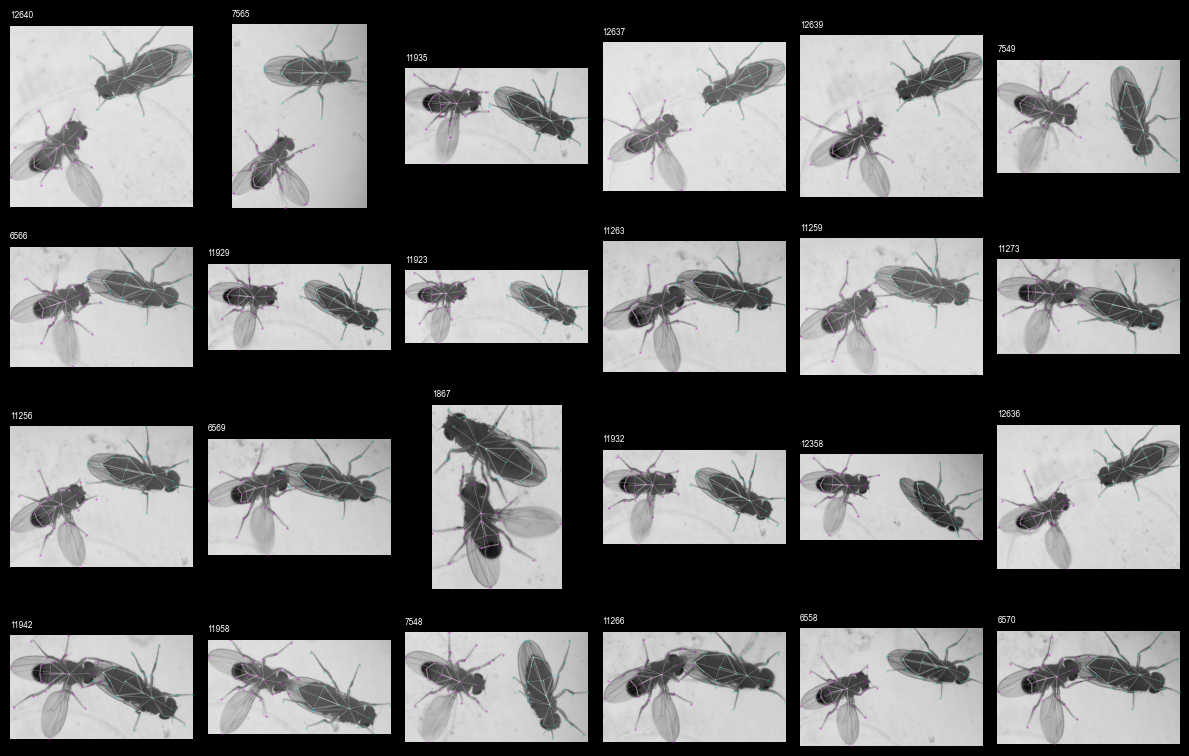

In [134]:
pcutoff=0.9 # keep this value HIGH, only include points that the network is confident about 
alphavalue=0.25
markersize=2

nr=4
nc=6
sorted_wing.sample(sorted_wing.shape[0])
figname = 'wing-ext-min-{}-max-{}-n{}'.format(wing_closed_angle, wing_open_angle, nr*nc)

fig, axn = pl.subplots(nr, nc, figsize=(nc*2, nr*2))
for ai, (ix, df_) in enumerate(sorted_wing.iterrows()):
    frame_ix = ix #['frame']
    if ai>=(nr*nc):
        break
    ax=axn.flat[ai]
    cap.set(1, frame_ix)
    ret, im = cap.read()
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) #COLOR_BGR2RGB)
    ax.imshow(im, cmap='gray')
    # skeletons
    for ind2plot in individuals:
        currcol = animal_colors[ind2plot]
        df = tracks.loc(axis=1)[:, ind2plot]
        # plot bodyparts
        putil.plot_bodyparts(df, frame_ix, bodyparts2plot, ax=ax, pcutoff=pcutoff,
                             color=currcol, alpha=alphavalue, markersize=markersize)
        # get current frame coords
        xyp = dlc.get_valid_coords(df, pcutoff=pcutoff)
        coords = xyp[frame_ix]
        # plot skeletons
        putil.plot_skeleton(coords, inds=inds_abdomen, ax=ax, color=skeleton_color, alpha=alphavalue, lw=lw)
        putil.plot_skeleton(coords, inds=inds_og, ax=ax, color=skeleton_color, alpha=alphavalue, lw=skeleton_lw)
    # axes
    nx = int(np.nanmax(tracks.xs("x", axis=1, level="coords").loc[frame_ix]))
    ny = int(np.nanmax(tracks.xs("y", axis=1, level="coords").loc[frame_ix]))
    nx_min = int(np.nanmin(tracks.xs("x", axis=1, level="coords").loc[frame_ix]))
    ny_min = int(np.nanmin(tracks.xs("y", axis=1, level="coords").loc[frame_ix]))
    ax.set_xlim(nx_min, nx)
    ax.set_ylim(ny_min, ny)
    ax.set_aspect(1)
    ax.axis('off')
    ax.set_title('{}'.format(frame_ix), loc='left', fontsize=6)
pl.tight_layout()

figpath = os.path.join(figdir, '{}_frames.png'.format(figname))
pl.savefig(figpath) #curr_figid
print(figpath)

In [ ]:
---> 15 cap.set(1, frame_ix)
